| **Chapter**               | 9:  Agent-based modeling                       |
|---------------------------|------------------------------------------------|
| **Computational Note**    | 9.15: SI-SIRD epidemic competition             |
|                           | 9.16: Competing pathogens with a modal shift   |
| **Package prerequisites** | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# SI-SIRD epidemic competition

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
import random
from matplotlib.lines import Line2D
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

mesa      : 0.9.0
pandas    : 1.4.2
numpy     : 1.21.6
json      : 2.0.9
scipy     : 1.8.1
matplotlib: 3.5.2
networkx  : 2.8.4



In [3]:
class StateA(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    DECEASED = 2

class StateB(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DECEASED = 3

In [4]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state_A = StateA.SUSCEPTIBLE
        self.state_B = StateB.SUSCEPTIBLE
        self.q_neighbourhood = []

    def set_q_neighbourhood(self):
        if self.state_B is StateB.INFECTED:
            neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False)) if agent.state_A is not StateA.DECEASED]

            self.q_neighbourhood = random.sample(neighbourhood, min(self.model.q, len(neighbourhood)))


    def contact_event(self):
        neighbourhood = self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False))
        
        susceptible_to_A = [agent for agent in neighbourhood if agent.state_A is StateA.SUSCEPTIBLE]
        susceptible_to_B = [agent for agent in neighbourhood if agent.state_B is StateB.SUSCEPTIBLE]


        if self.state_A is StateA.INFECTED:
            for neighbour in susceptible_to_A:
                if neighbour.state_B is StateB.INFECTED and self in neighbour.q_neighbourhood:
                    if np.random.rand() < self.model.beta_A * self.model.discount_factor:
                        neighbour.state_A = StateA.INFECTED
                elif neighbour.state_B is not StateB.INFECTED and np.random.rand() < self.model.beta_A:
                    neighbour.state_A = StateA.INFECTED
        
        if self.state_B is StateB.INFECTED:
            for neighbour in susceptible_to_B:
                if np.random.rand() < self.model.beta_B:
                    neighbour.state_B = StateB.INFECTED

    def status_update(self):        
        if self.state_B is StateB.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state_A, self.state_B = StateA.DECEASED, StateB.DECEASED
                else:
                    self.state_B = StateB.RECOVERED

        if self.state_B is StateB.INFECTED:
            self.set_q_neighbourhood()

        if np.random.rand() < self.model.base_mortality_rate:
            self.state_A, self.state_B = StateA.DECEASED, StateB.DECEASED


    def step(self):
        self.status_update()

        if self.state_A is StateA.INFECTED or self.state_B is StateB.INFECTED:
            self.contact_event()
    

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=30,
                 recovery_period=14,
                 beta_A=0.002,
                 beta_B=0.008,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.05,
                 discount_factor=0.1,
                 q=2):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.beta_A = beta_A
        self.beta_B = beta_B
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.discount_factor = discount_factor
        self.q = q

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state_A = StateA.INFECTED

            if np.random.rand() < I0:
                agent.state_B = StateB.INFECTED

        self.datacollector = DataCollector(agent_reporters={"State_A": "state_A", 
                                                            "State_B": "state_B"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 2000},
                                  iterations=15,
                                  max_steps=120,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [7]:
br.run_all()

15it [02:05,  8.34s/it]


In [8]:
A_tss, B_tss = map(lambda x: [pd.pivot_table(br.get_model_vars_dataframe().vals[i].get_agent_vars_dataframe().reset_index()[["Step", x]], 
                        index="Step", 
                        columns=x, 
                        aggfunc=np.size)[1].to_list() for i in range(len(br.get_model_vars_dataframe().vals))], ("State_A", "State_B"))

In [9]:
coinfections = list(map(lambda x: x[(x.State_A == 1) & (x.State_B == 1)][["Step"]].groupby("Step").size(), 
    [br.get_model_vars_dataframe().vals[i].get_agent_vars_dataframe().reset_index() for i in range(len(br.get_model_vars_dataframe().vals))]))

In [10]:
mu_A = pd.DataFrame(A_tss).mean(axis=0)
mu_B = pd.DataFrame(B_tss).mean(axis=0)
mu_coinfs = pd.DataFrame(coinfections).mean(axis=0)

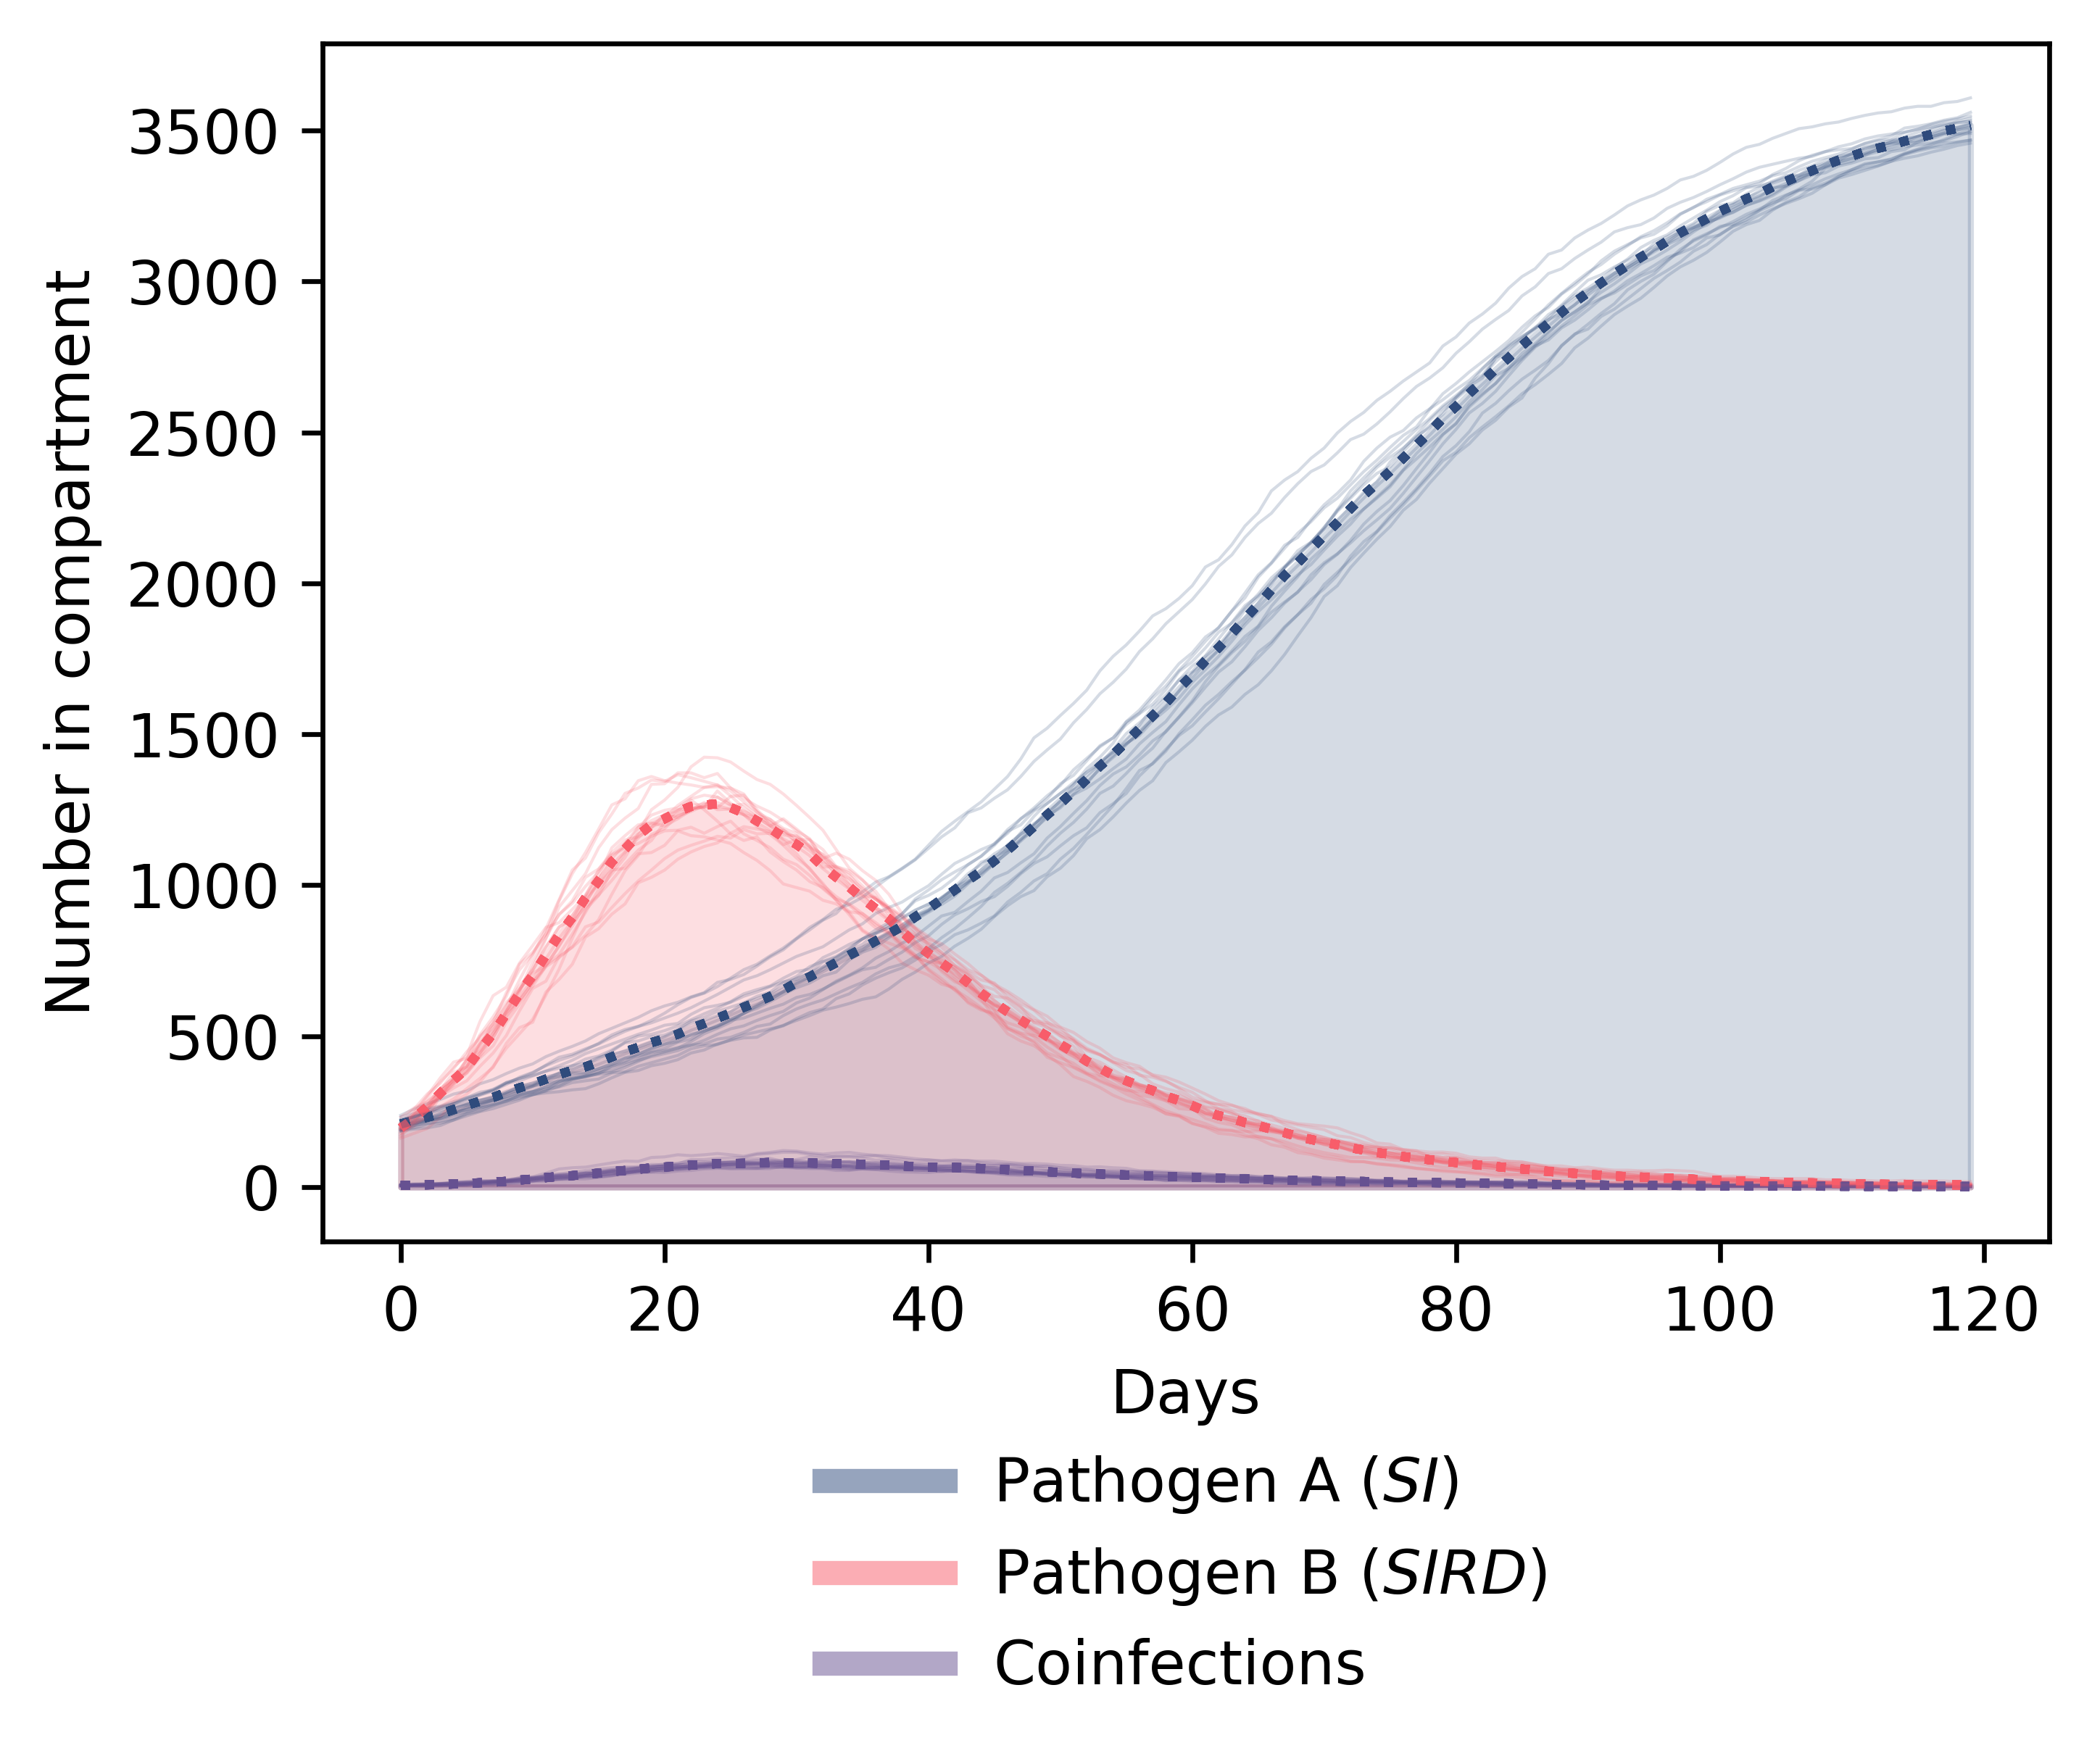

In [11]:
fig = plt.figure(facecolor="w", figsize=(6, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

for idx, val in enumerate(A_tss):
    ax.plot(A_tss[idx], color=COLORS["S"], alpha=0.2, lw=0.5)
    ax.plot(B_tss[idx], color=COLORS["I"], alpha=0.2, lw=0.5)
    ax.plot(coinfections[idx], color=COLORS["X"], alpha=0.2, lw=0.5)

    ax.plot(mu_A, color=COLORS["S"], lw=1.5, alpha=0.5, linestyle=":")

    ax.plot(mu_B, color=COLORS["I"], lw=1.5, alpha=0.5, linestyle=":")

    ax.plot(mu_coinfs, color=COLORS["X"], lw=1.5, alpha=0.5, linestyle=":")

ax.fill_between(np.arange(len(mu_A)), mu_A, 0, color=COLORS["S"], alpha=0.2)
ax.fill_between(np.arange(len(mu_B)), mu_B, 0, color=COLORS["I"], alpha=0.2)
ax.fill_between(np.arange(len(mu_coinfs)), mu_coinfs, 0, color=COLORS["X"], alpha=0.2)


legend_lines = [Line2D([0], [0], color=COLORS["S"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["I"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["X"], lw=4, alpha=0.5)]

ax.legend(legend_lines, ["Pathogen A ($SI$)", "Pathogen B ($SIRD$)", "Coinfections"], title="", bbox_to_anchor=(0.5, -0.425), loc="lower center", ncol=1, frameon=False)
ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("SI-SIRD_modulation_ABM.pdf")